In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import csv
%matplotlib inline
current_palette = sns.color_palette()

### Data from coach.me app

In [2]:
coachme_df = pd.read_csv('data/coach.me.export.20170331213146.csv')
coachme_df.head()

,Id,Habit,Date,Note,Check In Count,Days in Streak,Prop Count,Comment Count,URL
0,52275873,No watching TV,2016-01-12,NaN,4,1,0,0,https://www.coach.me/c/52275873
1,52275335,Wake Up By 8 AM,2016-01-13,NaN,53,1,0,0,https://www.coach.me/c/52275335
2,52289070,Exercise,2016-01-13,Strength training at the gym,111,1,0,0,https://www.coach.me/c/52289070
3,52364521,No watching TV,2016-01-15,NaN,4,1,0,0,https://www.coach.me/c/52364521
4,52364522,Wake Up By 8 AM,2016-01-15,NaN,53,1,0,0,https://www.coach.me/c/52364522


In [3]:
coachme_df.drop(['Id', 'Check In Count', 'Prop Count', 'Comment Count', 'URL'], axis=1, inplace=True)
coachme_df.head()

,Habit,Date,Note,Days in Streak
0,No watching TV,2016-01-12,NaN,1
1,Wake Up By 8 AM,2016-01-13,NaN,1
2,Exercise,2016-01-13,Strength training at the gym,1
3,No watching TV,2016-01-15,NaN,1
4,Wake Up By 8 AM,2016-01-15,NaN,1


Let's only look at data for the year 2016

In [4]:
coachme_df['Date'] = coachme_df['Date'].astype('datetime64[ns]')
coachme_df.set_index('Date', inplace=True)

In [5]:
coachme_2016_df = coachme_df[coachme_df.index.year == 2016]
coachme_2016_df.head(3)

,Habit,Note,Days in Streak
Date,,,
2016-01-12,No watching TV,NaN,1
2016-01-13,Wake Up By 8 AM,NaN,1
2016-01-13,Exercise,Strength training at the gym,1


The most reliable habit data here is the Exercise data.

Next, I logged my fitness activities on other apps too: Runkeeper and Fitbit.
Let me import 2016 data from Runkeeper first.

### Data from Runkeeper

In [6]:
runkeeper_df = pd.read_csv('data/runkeeper-cardioActivities.csv')
runkeeper_df['Date'] = runkeeper_df['Date'].astype('M8[D]')
runkeeper_df.set_index('Date', inplace=True)
runkeeper_df.head()

,Type,Route Name,Distance (mi),Duration,Average Pace,Average Speed (mph),Calories Burned,Climb (ft),Average Heart Rate (bpm),Notes,GPX File
Date,,,,,,,,,,,
2016-09-24,Running,NaN,2.42,31:46,13:08,4.57,225.0,99,NaN,NaN,2016-09-24-0853.gpx
2016-09-11,Running,NaN,1.85,26:16,14:12,4.23,158.0,7,NaN,NaN,2016-09-11-1909.gpx
2016-09-05,Hiking,NaN,7.58,3:06:39,24:37,2.44,754.0,278,NaN,NaN,2016-09-05-1117.gpx
2016-09-03,Running,NaN,1.23,16:47,13:38,4.40,113.0,53,NaN,NaN,2016-09-03-0935.gpx
2016-09-03,Running,NaN,0.00,8:24,NaN,NaN,0.0,0,NaN,NaN,NaN


For now, I am only going to retain the Type column.

In [7]:
runkeeper_df = pd.DataFrame(runkeeper_df.Type)
runkeeper_df = runkeeper_df[~runkeeper_df.index.duplicated()]
runkeeper_df.head()

,Type
Date,
2016-09-24,Running
2016-09-11,Running
2016-09-05,Hiking
2016-09-03,Running
2016-07-04,Hiking


In [8]:
exercise_df = coachme_2016_df[coachme_2016_df.Habit == 'Exercise'].copy()
exercise_df.drop(['Habit','Days in Streak'], axis=1, inplace=True)
exercise_df.rename(columns={'Note': 'Type'}, inplace=True)
exercise_df.Type.replace(np.nan, 'Not specified', inplace=True)
exercise_df.head()

,Type
Date,
2016-01-13,Strength training at the gym
2016-01-17,Not specified
2016-01-20,Strength training at gym
2016-01-22,Dance cardio workout
2016-01-23,Ab workout at home


Did I log any workouts on both apps?

In [9]:
common_rows = pd.merge(exercise_df, runkeeper_df, how='inner', left_index=True, right_index=True)
common_rows

,Type_x,Type_y
Date,,
2016-06-26,3 mile run,Running
2016-06-10,2.5 mile run,Running
2016-06-05,Morning run,Running


Okay, so it looks like I logged three running workouts on both apps. I should remove the duplicate records.

In [10]:
exercise_df = pd.concat([exercise_df, runkeeper_df], join='inner')
exercise_df.tail()

,Type
Date,
2016-07-04,Hiking
2016-06-26,Running
2016-06-12,Running
2016-06-10,Running
2016-06-05,Running


In [11]:
exercise_df.Type.count()

77

Now, let me remove any duplicate entries on both apps for the same day.

In [12]:
exercise_df = exercise_df[~exercise_df.index.duplicated()]
exercise_df.count()

Type    74
dtype: int64

Great, so that removed those 3 duplicate entries.


So it looks like I logged my exercise routines 74 times in 2016. Ignoring the two weeks of vacation in 2016, that comes to an average of 1.48 times per week. Note to self: need to get this number above 2 in 2017.

In [13]:
ex_by_month = exercise_df.groupby(exercise_df.index.month).size()
ex_by_month.rename(index=lambda x: datetime.datetime.strptime(str(x), '%m').strftime('%B'), inplace=True)
ex_by_month

January       8
February      6
March        10
April         2
May           7
June         13
July          8
August        5
September     9
October       3
November      3
dtype: int64

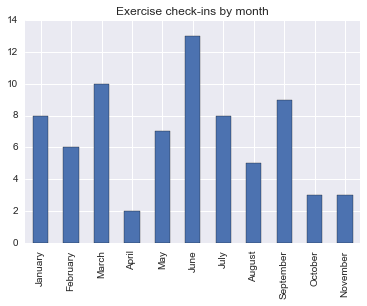

In [14]:
ex_by_month.plot(title='Exercise check-ins by month', kind='bar')

March and June were the best months for exercise. I logged no exercise in December(!) and just 2 days in April, which was the month of our 10-day vacation in Cambodia. 

I need to motivate myself to exercise indoors during the winter months and to not let a vacation throw the schedule so out of whack. October and November were also low-points, when work was heavy.

In [15]:
ex_by_day = exercise_df.groupby(exercise_df.index.dayofweek + 1).size() # Add 1 to account for dayofweek starting from 0
ex_by_day.rename(index=lambda x: datetime.datetime.strptime(str(x), '%d').strftime('%A'), inplace=True)
ex_by_day

Monday       30
Wednesday    29
Thursday      2
Friday        4
Saturday      3
Sunday        6
dtype: int64

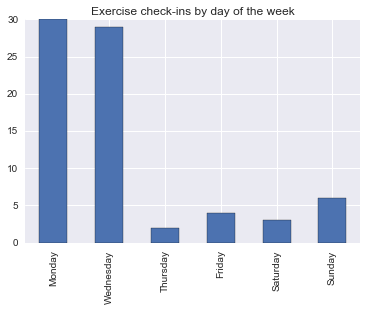

In [16]:
ex_by_day.plot(title='Exercise check-ins by day of the week', kind='bar')

As expected, most of my exercise check-ins were on Mondays and Wednesdays, i.e. the days of the strength class at my gym.

What did I do the rest of the days?

In [17]:
exercise_df.Type.value_counts()

Not specified                                                      39
Strength class                                                     15
Running                                                             4
Yoga class                                                          2
Hiking                                                              2
Core strength class                                                 1
Strength training class                                             1
Strength class. Can do about 4 push ups now.. Slowly improving.     1
3 mile run                                                          1
Class                                                               1
Ab workout at home                                                  1
Strength training at the gym                                        1
Yoga at the gym                                                     1
Strength training at gym                                            1
Morning run         

Okay, I clearly need a system to log the type of workout - there are so many duplicates here. And most of the time, I do not specify the type of workout.

Also, I received a Fitbit as a birthday gift last July! So let me export my data from Fitbit, starting from August.

### Data from Fitbit

In [18]:
fitbit_df = pd.read_csv('data/fitbit_export_2016.csv', thousands=',') # Handle commas as thousands separator
fitbit_df.head(3)

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2016-11-01,1563.0,2991.0,1.27,7.0,1440.0,0.0,0.0,0.0,0.0
1,2016-11-02,1690.0,4022.0,1.70,4.0,1440.0,0.0,0.0,0.0,0.0
2,2016-11-03,1563.0,3255.0,1.38,3.0,1408.0,32.0,0.0,0.0,96.0


In [19]:
fitbit_df.dropna(inplace=True)
fitbit_df['Date'] = fitbit_df['Date'].astype('datetime64[ns]')
fitbit_df.set_index('Date', inplace=True)
fitbit_df.sort_index(inplace=True)
fitbit_df.dropna(inplace=True)
fitbit_df.head(3)

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2016-08-01,1705.0,5592.0,2.37,4.0,1303.0,118.0,17.0,2.0,488.0
2016-08-02,1499.0,2260.0,0.96,2.0,888.0,78.0,0.0,0.0,220.0
2016-08-03,1721.0,4495.0,1.90,4.0,979.0,102.0,27.0,8.0,501.0


In [20]:
fitbit_df.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,1519.196078,2677.666667,1.149739,3.888889,1397.901961,29.300654,2.333333,1.529412,115.692810
std,202.894322,2992.734628,1.293591,6.878222,82.986585,45.507964,6.682656,6.152726,182.679554
min,1314.000000,0.000000,0.000000,0.000000,888.000000,0.000000,0.000000,0.000000,0.000000
25%,1321.000000,0.000000,0.000000,0.000000,1369.000000,0.000000,0.000000,0.000000,0.000000
50%,1524.000000,2657.000000,1.130000,2.000000,1440.000000,0.000000,0.000000,0.000000,0.000000
75%,1657.000000,4154.000000,1.760000,5.000000,1440.000000,64.000000,0.000000,0.000000,220.000000
max,2430.000000,21312.000000,9.030000,62.000000,1440.000000,168.000000,44.000000,53.000000,717.000000


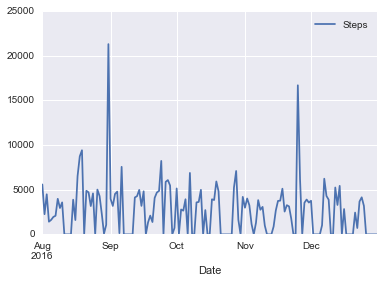

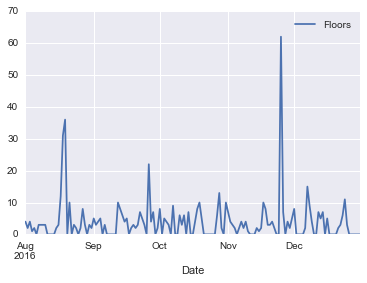

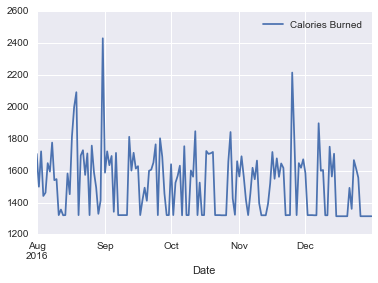

In [21]:
fitbit_df.plot(fitbit_df.index, 'Steps')
fitbit_df.plot(fitbit_df.index, 'Floors')
fitbit_df.plot(fitbit_df.index, 'Calories Burned')

In [22]:
fitbit_by_month = fitbit_df.groupby(fitbit_df.index.month).mean()
fitbit_by_month.rename(index=lambda x: datetime.datetime.strptime(str(x), '%m').strftime('%B'), inplace=True)
fitbit_by_month

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
August,1598.258065,3599.354839,1.529355,4.580645,1370.354839,27.516129,1.612903,0.322581,96.516129
September,1527.500000,3017.033333,1.338667,3.766667,1395.366667,37.400000,2.200000,5.033333,167.133333
October,1502.548387,2357.483871,1.004194,3.516129,1398.129032,33.870968,3.258065,0.838710,130.354839
November,1536.200000,2808.866667,1.196333,4.800000,1418.133333,19.400000,1.700000,0.766667,76.233333
December,1432.290323,1620.774194,0.687742,2.806452,1408.096774,28.258065,2.870968,0.774194,108.612903


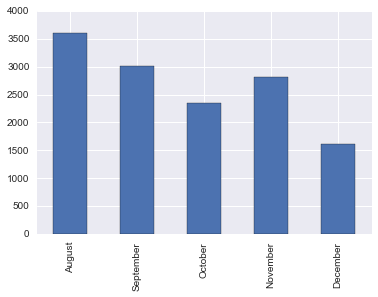

In [23]:
fitbit_by_month.Steps.plot(kind='bar')

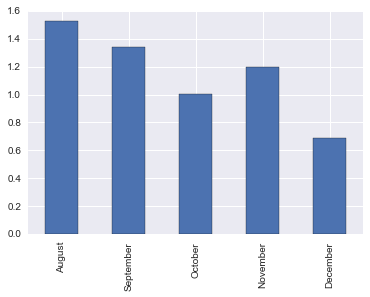

In [24]:
fitbit_by_month.Distance.plot(kind='bar')

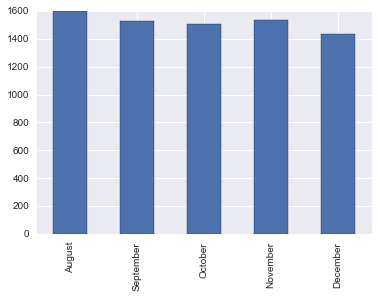

In [25]:
fitbit_by_month['Calories Burned'].plot(kind='bar')

In [26]:
fitbit_by_day = fitbit_df.groupby(fitbit_df.index.dayofweek + 1).mean() # Add 1 to account for dayofweek starting from 0
fitbit_by_day.rename(index=lambda x: datetime.datetime.strptime(str(x), '%d').strftime('%A'), inplace=True)
fitbit_by_day.head()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Monday,1562.136364,2804.090909,1.192273,4.090909,1387.681818,45.454545,3.681818,1.227273,169.772727
Tuesday,1505.318182,2680.136364,1.171818,3.045455,1380.818182,33.818182,2.136364,1.681818,131.090909
Wednesday,1649.318182,4476.454545,1.902273,4.409091,1342.954545,49.636364,6.818182,1.954545,205.681818
Thursday,1479.272727,2223.090909,0.944545,4.227273,1414.863636,24.181818,0.727273,0.227273,84.636364
Friday,1572.590909,3626.636364,1.550909,7.772727,1408.045455,27.818182,1.727273,2.409091,111.909091


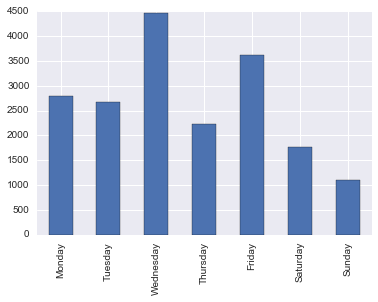

In [27]:
fitbit_by_day.Steps.plot(kind='bar')

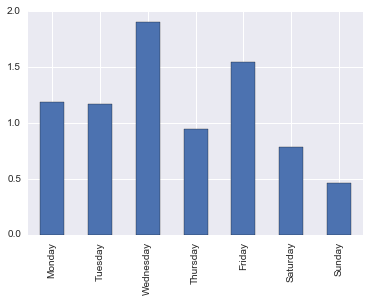

In [28]:
fitbit_by_day.Distance.plot(kind='bar')

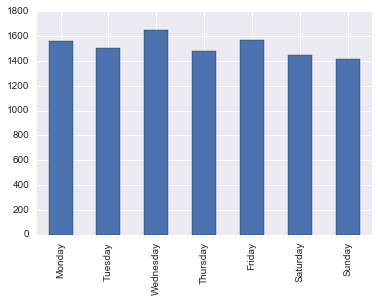

In [29]:
fitbit_by_day['Calories Burned'].plot(kind='bar')